Step 1: Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string #For text cleaning and preprocessing using regular expressions.
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer  #Converts text data into numerical form using TF-IDF
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression


Step 2: Load the Dataset

In [4]:
df = pd.read_csv("/content/Dataset-SA.csv")  # Replace with your actual file path
df.head()


,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


In [5]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205052 entries, 0 to 205051
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   205052 non-null  object
 1   product_price  205052 non-null  object
 2   Rate           205052 non-null  object
 3   Review         180388 non-null  object
 4   Summary        205041 non-null  object
 5   Sentiment      205052 non-null  object
dtypes: object(6)
memory usage: 9.4+ MB


Step 3: Handle Missing Values

In [6]:
df.isnull().sum()


,0
product_name,0
product_price,0
Rate,0
Review,24664
Summary,11
Sentiment,0


In [7]:
df['Sentiment'].value_counts()

,count
Sentiment,
positive,166581
negative,28232
neutral,10239


Step 4: Feature Engineering (Combine Summary and Review Columns into One)


In [8]:
df = df.dropna(subset=['Review', 'Summary'])
df = df.reset_index(drop=True)


In [9]:
df['text'] = df['Summary'].fillna('') + " " + df['Review'].fillna('')


In [10]:
df[['Summary', 'Review', 'text']].head()


,Summary,Review,text
0,great cooler excellent air flow and for this p...,super!,great cooler excellent air flow and for this p...
1,best budget 2 fit cooler nice cooling,awesome,best budget 2 fit cooler nice cooling awesome
2,the quality is good but the power of air is de...,fair,the quality is good but the power of air is de...
3,very bad product its a only a fan,useless product,very bad product its a only a fan useless product
4,ok ok product,fair,ok ok product fair


Step 5: Text Cleaning using Regex

In [11]:
import re

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+", '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['clean_text'] = df['text'].apply(clean_text)


In [12]:
df[['text', 'clean_text']].head()


,text,clean_text
0,great cooler excellent air flow and for this p...,great cooler excellent air flow and for this p...
1,best budget 2 fit cooler nice cooling awesome,best budget fit cooler nice cooling awesome
2,the quality is good but the power of air is de...,the quality is good but the power of air is de...
3,very bad product its a only a fan useless product,very bad product its a only a fan useless product
4,ok ok product fair,ok ok product fair


Step 6: Encode Sentiment Labels

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['Sentiment'])


In [14]:
print(le.classes_)  # ['Negative', 'Neutral', 'Positive']


['negative' 'neutral' 'positive']


Step 7: Train-Test Split

In [15]:
X = df['clean_text']  # Feature: cleaned review text
y = df['label']       # Target: encoded sentiment

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Step 8: TF-IDF Vectorization (to represent text based on the importance of words across all reviews.)

In [16]:
tfidf = TfidfVectorizer(max_features=5000)  # You can adjust this number

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

In [17]:
print(X_train_vec.shape, X_test_vec.shape)


(144303, 5000) (36076, 5000)


Step 9: Train a Logistic Regression Model

In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)


LogisticRegression(max_iter=1000)

Step 10: Model Evaluation

In [20]:
# Predict on test set
y_pred = model.predict(X_test_vec)
y_pred

array([2, 0, 2, ..., 0, 2, 0])

In [21]:
# Text report
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      4880
     neutral       0.70      0.39      0.50      1762
    positive       0.96      0.98      0.97     29434

    accuracy                           0.93     36076
   macro avg       0.83      0.74      0.77     36076
weighted avg       0.93      0.93      0.93     36076



In [22]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

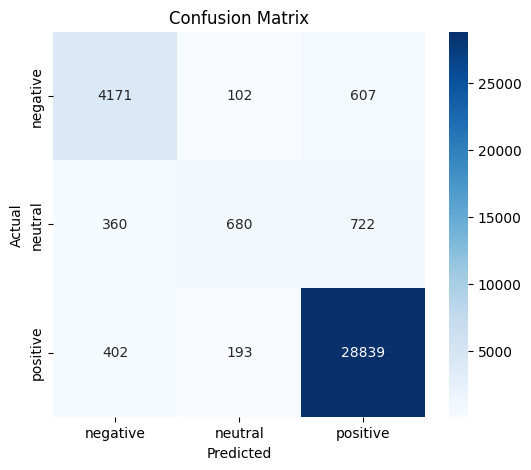

In [23]:
# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Step 11: Model Improvement Strategy (Use class_weight='balanced' in Logistic Regression)

In [24]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

    negative       0.80      0.86      0.83      4880
     neutral       0.31      0.70      0.43      1762
    positive       0.99      0.90      0.94     29434

    accuracy                           0.88     36076
   macro avg       0.70      0.82      0.73     36076
weighted avg       0.93      0.88      0.90     36076



Step 12: Train an SVM Classifier

In [25]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(class_weight='balanced')
svm_model.fit(X_train_vec, y_train)

y_pred_svm = svm_model.predict(X_test_vec)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))


              precision    recall  f1-score   support

    negative       0.81      0.87      0.84      4880
     neutral       0.45      0.55      0.50      1762
    positive       0.98      0.95      0.96     29434

    accuracy                           0.92     36076
   macro avg       0.75      0.79      0.77     36076
weighted avg       0.93      0.92      0.92     36076



Step 13: Predict on a Trial Input


In [26]:
def predict_sentiment(text):
    # Clean the text (use the same function as before)
    cleaned = clean_text(text)

    # Vectorize using the same TF-IDF vectorizer
    vec = tfidf.transform([cleaned])

    # Predict using SVM
    pred = svm_model.predict(vec)[0]

    # Map back to original label
    sentiment = le.inverse_transform([pred])[0]

    return sentiment


In [27]:
# Example input (you can change this)
trial = "The product quality is amazing and delivery was super fast!"
print("Predicted Sentiment:", predict_sentiment(trial))


Predicted Sentiment: positive


In [28]:
# Example input (you can change this)
trial = "It stopped working after 2 days. Total waste of money"
print("Predicted Sentiment:", predict_sentiment(trial))

Predicted Sentiment: negative


In [29]:
# Example input (you can change this)
trial = "Okay product. Not great, not bad"
print("Predicted Sentiment:", predict_sentiment(trial))

Predicted Sentiment: negative


In [30]:
# Example input (you can change this)
trial = "Absolutely love it! Worth every penny."
print("Predicted Sentiment:", predict_sentiment(trial))

Predicted Sentiment: positive


In [31]:
print(predict_sentiment("The product is okay, does the job."))             # Neutral
print(predict_sentiment("It's an average product. Nothing special."))      # Neutral
print(predict_sentiment("I received it yesterday. Haven't tried yet."))    # Neutral
print(predict_sentiment("Product arrived on time, looks fine so far."))    # Neutral
print(predict_sentiment("Packaging was decent. Yet to use the item."))     # Neutral


neutral
neutral
neutral
positive
neutral


Step 14: Save the Model, Vectorizer & Label Encoder

In [32]:
import joblib

# Save model
joblib.dump(svm_model, "sentiment_svm_model.pkl")

# Save TF-IDF vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

# Save Label Encoder
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']